## Часть 1.Обучение модели для задачи Document Question Answering [2 балла]

**Цель:** отработать навыки работы с мультимодальностью на задаче Document Question Answering.

В этой части задания вам предстоит ознакомиться с обучением модели Document Question Answering. Вы можете пропустить эту часть и начать делать уже следующую, для них уже есть обученная готовая модель. Тут вам нужно лишь пройти по ноутбуку и посмотреть на процесс обучения. Он может занять продолжительное время.

---

**Ожидаемый результат.** В качестве результатов в этой части вам нужно представить обученную модели и показать результаты ее работы, посчитав долю правильных ответов на вопросы.



In [ ]:
# Раскомментируйте

# ! pip install transformers datasets
# ! pip install 'git+https://github.com/facebookresearch/detectron2.git'

# !sudo apt install tesseract-ocr
# !pip install -q pytesseract

# Задача ответов на вопросы в документе

Задача ответов на вопросы по документу, также называемая визуальными ответами на вопросы по документу, — это задача, которая включает в себя предоставление ответов на вопросы об изображениях документов. Входные данные для моделей, поддерживающих эту задачу, обычно представляют собой комбинацию изображения и вопрос, а результатом является ответ, выраженный на естественном языке. Эти модели используют несколько модальностей, в том числе текст, положение слов (ограничивающие рамки) и само изображение.

В этом руководстве показано:

- Как дообучать [LayoutLMv2](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/layoutlmv2) в [наборе данных DocVQA](https://huggingface.co/datasets/nielsr/docvqa_1200_examples_donut).
- Как использовать свою тонко настроенную модель для вывода.

<Tip>

Задача, проиллюстрированная в этом руководстве, поддерживается следующими архитектурами моделей:

<!--Этот совет генерируется автоматически командой make fix-copies, не заполняйте вручную!-->

[LayoutLM](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/layoutlm), [LayoutLMv2](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/layoutlmv2), [LayoutLMv3](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/layoutlmv3)

LayoutLMv2 решает задачу ответов на вопросы в документе, добавляя заголовок ответа на вопрос поверх конечных скрытых состояний токенов, чтобы предсказать положения начальных и конечных токенов ответа. Другими словами, проблема рассматривается как экстрактивный ответ на вопрос: учитывая контекст, извлеките, какая часть информации отвечает на вопрос. Контекст получается из результатов работы механизма OCR, здесь это Tesseract от Google.

Прежде чем начать, убедитесь, что у вас установлены все необходимые библиотеки. LayoutLMv2 зависит от detectron2, torchvision and tesseract.

```bash
pip install -q transformers datasets
```

```bash
pip install 'git+https://github.com/facebookresearch/detectron2.git'
pip install torchvision
```

```bash
sudo apt install tesseract-ocr
pip install -q pytesseract
```

После установки всех зависимостей перезапустите среду выполнения.

Мы рекомендуем вам поделиться своей моделью с сообществом. Войдите в свою учетную запись Hugging Face, чтобы загрузить его в 🤗 Hub.
При появлении запроса введите свой токен для входа:

Давайте определим некоторые глобальные переменные.

In [ ]:
model_checkpoint = "microsoft/layoutlmv2-base-uncased"
batch_size = 4

## Загрузка данных

В этом руководстве мы используем небольшой образец предварительно обработанного DocVQA, который вы можете найти на 🤗 Hub. Если вы хотите использовать полный набор данных DocVQA, вы можете зарегистрировать и загрузить его на [DocVQA](https://rrc.cvc.uab.es/?ch=17). Если вы это сделаете, чтобы продолжить работу с этим руководством, ознакомьтесь с [как загрузить файлы в набор данных 🤗](https://huggingface.co/docs/datasets/loading#local-and-remote-files).

In [ ]:
from datasets import load_dataset

dataset = load_dataset("nielsr/docvqa_1200_examples")
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'image', 'query', 'answers', 'words', 'bounding_boxes', 'answer'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['id', 'image', 'query', 'answers', 'words', 'bounding_boxes', 'answer'],
        num_rows: 200
    })
})

Как видите, датасет уже разделен на обучающий и тестовый наборы. Взгляните на случайный пример, чтобы ознакомиться с признаками.

In [ ]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'image': Image(decode=True, id=None),
 'query': {'de': Value(dtype='string', id=None),
  'en': Value(dtype='string', id=None),
  'es': Value(dtype='string', id=None),
  'fr': Value(dtype='string', id=None),
  'it': Value(dtype='string', id=None)},
 'answers': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bounding_boxes': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), length=-1, id=None),
 'answer': {'match_score': Value(dtype='float64', id=None),
  'matched_text': Value(dtype='string', id=None),
  'start': Value(dtype='int64', id=None),
  'text': Value(dtype='string', id=None)}}

Вот что представляют собой отдельные поля:
* `id`: идентификатор примера.
* `image`: объект PIL.Image.Image, содержащий изображение документа.
* `query`: строка вопроса - вопрос, заданный на естественном языке, на нескольких языках.
* `answers`: список правильных ответов, предоставленных комментаторами-людьми.
* `words` и `bounding_boxes`: результаты OCR, которые мы здесь использовать не будем.
* `answer`: ответ, соответствующий другой модели, которую мы здесь не будем использовать.

Давайте оставим только вопросы на английском языке и удалим признак `answer`, который, по всей видимости, содержит прогнозы другой модели.
Мы также возьмем первый из ответов из набора, предоставленного аннотаторами. Альтернативно, вы можете выбрать его случайным образом.

In [ ]:
updated_dataset = dataset.map(lambda example: {"question": example["query"]["en"]}, remove_columns=["query"])
updated_dataset = updated_dataset.map(
    lambda example: {"answer": example["answers"][0]}, remove_columns=["answer", "answers"]
)

Обратите внимание, что чекпоинт LayoutLMv2, который мы используем в этом руководстве, был обучен с помощью `max_position_embeddings = 512` (вы можете найти эту информацию в [файле `config.json` чекпоинта](https://huggingface.co/microsoft/layoutlmv2-base-uncased/blob/main/config.json#L18)).
Мы можем урезать примеры, но чтобы избежать ситуации, когда ответ может находиться в конце большого документа и в конечном итоге быть усеченным, здесь мы удалим несколько примеров, в которых вложение может оказаться длиннее 512.
Если большинство документов в вашем наборе данных длинные, вы можете реализовать стратегию скользящего окна — подробности см. в [этот блокнот](https://github.com/huggingface/notebooks/blob/main/examples/question_answering.ipynb).

In [ ]:
updated_dataset = updated_dataset.filter(lambda x: len(x["words"]) + len(x["question"].split()) < 512)

На этом этапе давайте также удалим признаки OCR (оптическое распознавание символов) из этого набора данных. Это результат OCR для тонкой настройки другой модели. Если бы мы захотели их использовать, они все равно потребовали бы некоторой обработки, поскольку они не соответствуют входным требованиям модели, которую мы используем в этом руководстве. Вместо этого мы можем использовать [LayoutLMv2Processor](https://huggingface.co/docs/transformers/main/en/model_doc/layoutlmv2#transformers.LayoutLMv2Processor) для исходных данных как для OCR, так и для токенизации. Таким образом, мы получим входные данные, соответствующие ожидаемым входным данным модели. Если вы хотите обрабатывать изображения вручную, ознакомьтесь с [документацией модели `LayoutLMv2`](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/layoutlmv2), чтобы узнать, какой формат ввода модель ожидает.

In [ ]:
updated_dataset = updated_dataset.remove_columns("words")
updated_dataset = updated_dataset.remove_columns("bounding_boxes")

Наконец, исследование данных не будет полным, если мы не взглянем на пример изображения.

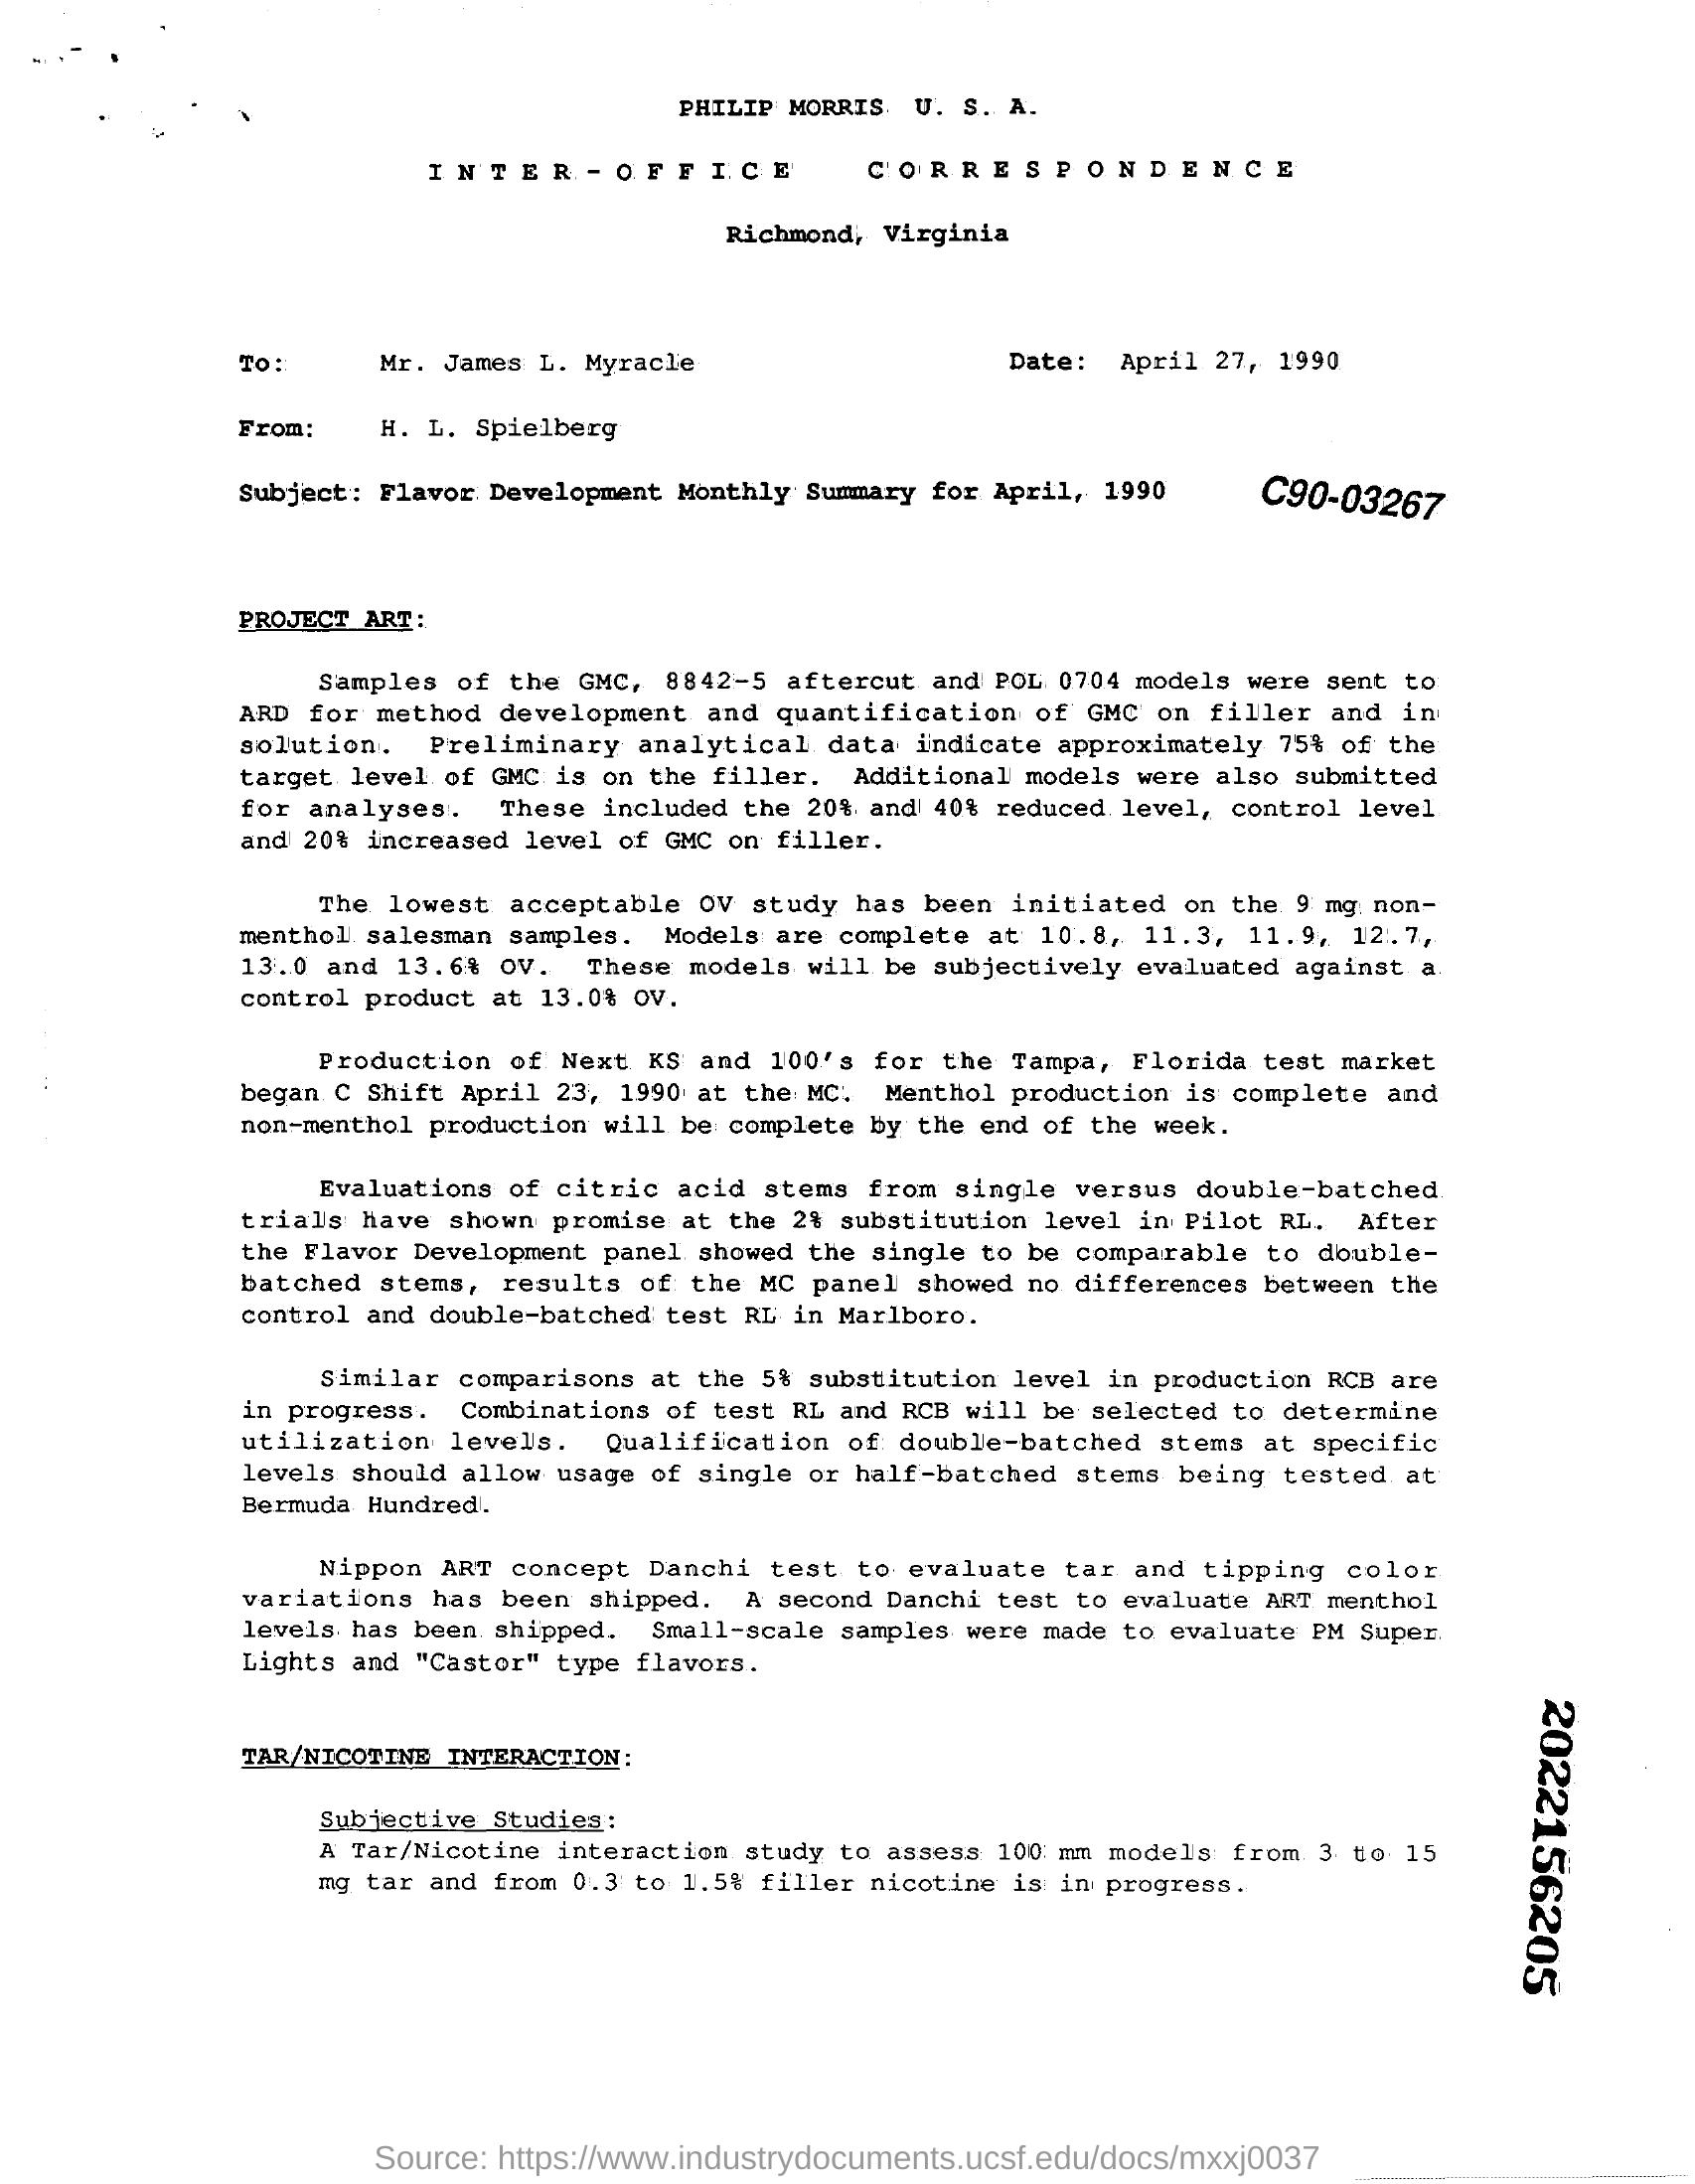

In [ ]:
updated_dataset["train"][11]["image"]

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/docvqa_example.jpg" alt="DocVQA Image Example"/>
 </div>

## Предварительная обработка данных

Задача ответов на вопросы по документу является мультимодальной задачей, и вам необходимо убедиться, что входные данные каждой модальности
предварительно обрабатываются в соответствии с ожиданиями модели. Начнем с загрузки [LayoutLMv2Processor](https://huggingface.co/docs/transformers/main/en/model_doc/layoutlmv2#transformers.LayoutLMv2Processor), который внутри объединяет процессор изображений, который может обрабатывать данные изображения, и токенизатор, который может кодировать текстовые данные.

In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(model_checkpoint)

### Предварительная обработка изображений документов

Для начала подготовим изображения документов для модели с помощью `image_processor` процессора. По умолчанию процессор изображений изменяет размер изображений до 224x224, проверяет правильный порядок цветовых каналов, применяет OCR с tesseract для получения слов и нормализованных ограничивающих рамок (bounding boxes). В этом уроке все эти значения по умолчанию — именно то, что нам нужно. Напишите функцию, которая применяет обработку изображений по умолчанию к батчу изображений и возвращает результаты OCR.

In [ ]:
image_processor = processor.image_processor


def get_ocr_words_and_boxes(examples):
    images = [image.convert("RGB") for image in examples["image"]]
    encoded_inputs = image_processor(images)

    examples["image"] = encoded_inputs.pixel_values
    examples["words"] = encoded_inputs.words
    examples["boxes"] = encoded_inputs.boxes

    return examples

Чтобы быстро применить эту предварительную обработку ко всему набору данных, используйте [map](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.map).

In [ ]:
dataset_with_ocr = updated_dataset.map(get_ocr_words_and_boxes, batched=True, batch_size=16)

Map:   0%|          | 0/904 [00:00<?, ? examples/s]

KeyboardInterrupt: ignored

### Предварительная обработка текстовых данных

После того как мы применили OCR к изображениям, нам нужно закодировать текстовую часть набора данных, чтобы подготовить ее для модели. Это включает в себя преобразование слов и bounding boxes, которые мы получили на предыдущем шаге, в `input_ids`, `attention_mask`, `token_type_ids` и `bbox` уровня токена. Для предварительной обработки текста нам понадобится токенизатор процессора.

In [ ]:
tokenizer = processor.tokenizer

Помимо упомянутой выше предварительной обработки, нам также необходимо добавить метки для модели. Для моделей `xxxForQuestionAnswering` в 🤗 Transformers метки состоят из `start_positions` и `end_positions`, указывающих, какой токен находится в начале, а какой токен — в конце ответа.

Начнем с этого. Определите вспомогательную функцию, которая может найти подсписок (ответ, разделенный на слова) в более крупном списке (списке слов).

Эта функция будет принимать на вход два списка:`words_list` и `answer_list`. Затем он будет перебирать `words_list` и проверять
равно ли текущее слово в `words_list` (words_list[i]) первому слову в (answer_list[0]) и равен ли подсписок `words_list`, начинающийся с текущего слова и той же длины, что и `answer_list` списку `response_list`.
Если это условие истинно, это означает, что совпадение найдено, и функция запишет совпадение, его начальный индекс (idx) и конечный индекс (idx + len(answer_list) - 1). Если найдено более одного совпадения, функция вернет только первое.
Если совпадение не найдено, функция возвращает (`None`, 0, и 0).

In [ ]:
def subfinder(words_list, answer_list):
    matches = []
    start_indices = []
    end_indices = []
    for idx, i in enumerate(range(len(words_list))):
        if words_list[i] == answer_list[0] and words_list[i : i + len(answer_list)] == answer_list:
            matches.append(answer_list)
            start_indices.append(idx)
            end_indices.append(idx + len(answer_list) - 1)
    if matches:
        return matches[0], start_indices[0], end_indices[0]
    else:
        return None, 0, 0

Чтобы проиллюстрировать, как эта функция находит позицию ответа, давайте воспользуемся ею на примере:

In [ ]:
example = dataset_with_ocr["train"][1]
words = [word.lower() for word in example["words"]]
match, word_idx_start, word_idx_end = subfinder(words, example["answer"].lower().split())
print("Question: ", example["question"])
print("Words:", words)
print("Answer: ", example["answer"])
print("start_index", word_idx_start)
print("end_index", word_idx_end)

NameError: ignored

Однако после кодирования примеров они будут выглядеть так:

In [ ]:
encoding = tokenizer(example["question"], example["words"], example["boxes"])
tokenizer.decode(encoding["input_ids"])

NameError: ignored

Нам нужно будет найти позицию ответа в закодированном вводе.
* `token_type_ids` сообщает нам, какие токены являются частью вопроса, а какие — частью слов документа.
* `tokenizer.cls_token_id` поможет найти специальный токен в начале ввода.
* `word_ids` поможет сопоставить ответ, найденный в исходных `words`, с тем же ответом в полностью закодированных входных данных и определить начальную/конечную позицию ответа в закодированном вводе.

Имея это в виду, давайте создадим функцию для кодирования батча примеров в наборе данных:

In [ ]:
def encode_dataset(examples, max_length=512):
    questions = examples["question"]
    words = examples["words"]
    boxes = examples["boxes"]
    answers = examples["answer"]

    # encode the batch of examples and initialize the start_positions and end_positions
    encoding = tokenizer(questions, words, boxes, max_length=max_length, padding="max_length", truncation=True)
    start_positions = []
    end_positions = []

    # loop through the examples in the batch
    for i in range(len(questions)):
        cls_index = encoding["input_ids"][i].index(tokenizer.cls_token_id)

        # find the position of the answer in example's words
        words_example = [word.lower() for word in words[i]]
        answer = answers[i]
        match, word_idx_start, word_idx_end = subfinder(words_example, answer.lower().split())

        if match:
            # if match is found, use `token_type_ids` to find where words start in the encoding
            token_type_ids = encoding["token_type_ids"][i]
            token_start_index = 0
            while token_type_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(encoding["input_ids"][i]) - 1
            while token_type_ids[token_end_index] != 1:
                token_end_index -= 1

            word_ids = encoding.word_ids(i)[token_start_index : token_end_index + 1]
            start_position = cls_index
            end_position = cls_index

            # loop over word_ids and increase `token_start_index` until it matches the answer position in words
            # once it matches, save the `token_start_index` as the `start_position` of the answer in the encoding
            for id in word_ids:
                if id == word_idx_start:
                    start_position = token_start_index
                else:
                    token_start_index += 1

            # similarly loop over `word_ids` starting from the end to find the `end_position` of the answer
            for id in word_ids[::-1]:
                if id == word_idx_end:
                    end_position = token_end_index
                else:
                    token_end_index -= 1

            start_positions.append(start_position)
            end_positions.append(end_position)

        else:
            start_positions.append(cls_index)
            end_positions.append(cls_index)

    encoding["image"] = examples["image"]
    encoding["start_positions"] = start_positions
    encoding["end_positions"] = end_positions

    return encoding

Теперь, когда у нас есть функция предварительной обработки, мы можем закодировать весь набор данных:

In [ ]:
encoded_train_dataset = dataset_with_ocr["train"].map(
    encode_dataset, batched=True, batch_size=2, remove_columns=dataset_with_ocr["train"].column_names
)
encoded_test_dataset = dataset_with_ocr["test"].map(
    encode_dataset, batched=True, batch_size=2, remove_columns=dataset_with_ocr["test"].column_names
)

NameError: ignored

Давайте проверим, как выглядят признаки закодированного набора данных:

In [ ]:
encoded_train_dataset.features

NameError: ignored

## Оценка

Оценка ответа на вопросы документа требует значительного объема постобработки. Чтобы не брать на себя слишком много
вашего времени, это руководство пропускает этап оценки. [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) по-прежнему рассчитывает потери оценки во время обучения, поэтому вы не находитесь в полном неведении относительно производительности вашей модели. Экстрактивный ответ на вопрос обычно оценивается с помощью F1/точного соответствия.
Если вы хотите реализовать это самостоятельно, для вдохновения ознакомьтесь с [главой «Question Answering»](https://huggingface.co/course/chapter7/7?fw=pt#postprocessing) курса Hugging Face.

## Обучение

Поздравляем! Вы успешно прошли самую сложную часть этого руководства и теперь готовы обучать свою собственную модель.
Обучение включает в себя следующие этапы:
* Загрузите модель с помощью [AutoModelForDocumentQuestionAnswering](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForDocumentQuestionAnswering), используя тот же чекпоинт, что и при предварительной обработке.
* Определите гиперпараметры обучения в [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
* Определите функцию для обработки батчей примеров, здесь [DefaultDataCollator](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DefaultDataCollator) вполне подойдет.
* Передайте аргументы обучения [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) вместе с моделью, набором данных и средством сборки данных.
* Вызовите [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train), чтобы тонко настроить вашу модель.

In [ ]:
from transformers import AutoModelForDocumentQuestionAnswering

model = AutoModelForDocumentQuestionAnswering.from_pretrained(model_checkpoint)

ImportError: ignored

В [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) используйте `output_dir`, чтобы указать, где сохранить вашу модель, и настройте гиперпараметры по своему усмотрению.
Если вы хотите поделиться своей моделью с сообществом, установите для параметра `push_to_hub` значение `True` (вы должны войти в Hugging Face, чтобы загрузить свою модель).
В этом случае `output_dir` также будет именем репозитория, куда будет помещен чекпоинт вашей модели.

In [ ]:
from transformers import TrainingArguments

# REPLACE THIS WITH YOUR REPO ID
repo_id = "MariaK/layoutlmv2-base-uncased_finetuned_docvqa"

training_args = TrainingArguments(
    output_dir=repo_id,
    per_device_train_batch_size=4,
    num_train_epochs=20,
    save_steps=200,
    logging_steps=50,
    evaluation_strategy="steps",
    learning_rate=5e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

Определите простой механизм сборки данных для группирования примеров.

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

Наконец, соберите все вместе и вызовите [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_test_dataset,
    tokenizer=processor,
)

trainer.train()